# TCGA-KIPAN Analysis: Using *BioNeuralNet* for Interpretability and Biomarker Discovery

- **Cohort**: Focuses on the TCGA-KIPAN dataset, a vital resource merging three major kidney cancer subtypes:
    - `Kidney Renal Clear Cell Carcinoma` (KIRC)
    - `Kidney Renal Papillary Cell Carcinoma` (KIRP)
    - `Kidney Chromophobe `(KICH)

- **Goal**: Perform histological subtype classification.
- **Prediction Target**: Predict the specific kidney cancer subtype (`KIRC`, `KIRP`, or `KICH`) from its multi-omics profile.

**Data Source:** Broad Institute FireHose(`http://firebrowse.org/?cohort=KIPAN`)

In [ ]:
import pandas as pd
from pathlib import Path
root = Path("/home/vicente/Github/BioNeuralNet/KIPAN")

mirna_raw = pd.read_csv(root/"KIPAN.miRseq_RPKM_log2.txt", sep="\t",index_col=0,low_memory=False)                            
rna_raw = pd.read_csv(root / "KIPAN.uncv2.mRNAseq_RSEM_normalized_log2.txt", sep="\t",index_col=0,low_memory=False)
meth_raw = pd.read_csv(root/"KIPAN.meth.by_mean.data.txt", sep='\t',index_col=0,low_memory=False)
clinical_raw = pd.read_csv(root / "KIPAN.clin.merged.picked.txt",sep="\t", index_col=0, low_memory=False)

# display all shapes and first few rows of each dataset
display(mirna_raw.iloc[:3,:5])
display(mirna_raw.shape)

display(rna_raw.iloc[:3,:5])
display(meth_raw.shape)

display(meth_raw.iloc[:3,:5])
display(meth_raw.shape)

display(clinical_raw.iloc[:3,:5])
display(clinical_raw.shape)

## Data Processing Summary

1. **Transpose Data:** All raw data (miRNA, RNA, etc.) is flipped so rows represent patients and columns represent features.
2. **Standardize Patient IDs:** Patient IDs in all tables are cleaned to the 12-character TCGA format (e.g., `TCGA-AB-1234`) for matching.
3. **Handle Duplicates:** Duplicate patient rows are averaged in the omics data. The first entry is kept for duplicate patients in the clinical data.
4. **Find Common Patients:** The script identifies the list of patients that exist in *all* datasets.
5. **Subset Data:** All data tables are filtered down to *only* this common list of patients, ensuring alignment.
6. **Extract Target:** The `histological_type` column is pulled from the processed clinical data to be used as the prediction target (y-variable).

In [ ]:
mirna = mirna_raw.T
rna = rna_raw.T
meth = meth_raw.T
clinical = clinical_raw.T

print(f"miRNA (samples, features): {mirna.shape}")
print(f"RNA (samples, features): {rna.shape}")
print(f"Methylation (samples, features): {meth.shape}")
print(f"Clinical (samples, features): {clinical.shape}")

def trim_barcode(idx):
    return idx.to_series().str.slice(0, 12)

# standarized patient IDs across all files
meth.index = trim_barcode(meth.index)
rna.index = trim_barcode(rna.index)
mirna.index = trim_barcode(mirna.index)
clinical.index = clinical.index.str.upper()
clinical.index.name = "Patient_ID"

# convert all data to numeric, coercing errors to NaN
meth = meth.apply(pd.to_numeric, errors='coerce')
rna = rna.apply(pd.to_numeric, errors='coerce')
mirna = mirna.apply(pd.to_numeric, errors='coerce')

# for any duplicate columns in the omics data, we average their values
meth = meth.groupby(meth.index).mean()
rna = rna.groupby(rna.index).mean()
mirna = mirna.groupby(mirna.index).mean()

# for any duplicate rows in the clinical data, we keep the first occurrence
clinical = clinical[~clinical.index.duplicated(keep='first')]

print(f"\nMethylation shape: {meth.shape}")
print(f"RNA shape: {rna.shape}")
print(f"miRNA shape: {mirna.shape}")
print(f"Clinical shape: {clinical.shape}")

for df in [meth, rna, mirna]:
    df.columns = df.columns.str.replace(r"\?", "unknown_", regex=True)
    df.columns = df.columns.str.replace(r"\|", "_", regex=True)
    df.columns = df.columns.str.replace("-", "_", regex=False)
    df.columns = df.columns.str.replace(r"_+", "_", regex=True)
    df.columns = df.columns.str.strip("_")
    
    df.fillna(df.mean(), inplace=True)

# to see which pateints are common across all data files
common_patients = sorted(list(set(meth.index)&set(rna.index)&set(mirna.index)&set(clinical.index)))

print(f"\nFound: {len(common_patients)} patients across all data types.")

# subset to only common patients
meth_processed = meth.loc[common_patients]
rna_processed= rna.loc[common_patients]
mirna_processed = mirna.loc[common_patients]
clinical_processed = clinical.loc[common_patients]

# extract target labels from clinical data
targets = clinical_processed['histological_type']

In [ ]:
display(mirna_processed.iloc[:3,:5])
display(mirna_processed.shape)

display(rna_processed.iloc[:3,:5])
display(rna_processed.shape)

display(meth_processed.iloc[:3,:5])
display(meth_processed.shape)

display(clinical_processed.iloc[:3,:5])
display(clinical_processed.shape)

display(targets.value_counts())

In [ ]:
import bioneuralnet as bnn

# drop unwanted columns from clinical data
clinical_processed.drop(columns=["Composite Element REF"], errors="ignore", inplace=True)

# we transform the methylation beta values to M-values and drop unwanted columns
meth_m = meth_processed.drop(columns=["Composite Element REF"], errors="ignore")

# convert beta values to M-values using bioneuralnet utility with small epsilon to avoid log(0)
meth_m = bnn.utils.beta_to_m(meth_m, eps=1e-6) 

# lastly we turn the target labels into numerical classes
mapping = {"kidney clear cell renal carcinoma": 0, "kidney papillary renal cell carcinoma": 1, "kidney chromophobe": 2}
target_labels = targets.map(mapping).to_frame(name="target")

# as a safety check we align the indices once more
X_meth = meth_m.loc[common_patients]
X_rna = rna_processed.loc[common_patients]
X_mirna = mirna_processed.loc[common_patients]
Y_labels = target_labels.loc[common_patients]
clinical_final = clinical_processed.loc[common_patients]

print(f"\nDNA_Methylation shape: {X_meth.shape}")
print(f"RNA shape: {X_rna.shape}")
print(f"miRNA shape: {X_mirna.shape}")
print(f"Clinical shape: {clinical_final.shape}")
print(Y_labels.value_counts())

## Feature Selection Methodology

### Supported Methods and Interpretation

**BioNeuralNet** provides three techniques for feature selection, allowing for different views of the data's statistical profile:

- **Variance Thresholding:** Identifies features with the **highest overall variance** across all samples.

- **ANOVA F-test:** Pinpoints features that best **distinguish between the target classes** (KIRC, KIRP, and KICH).

- **Random Forest Importance:** Assesses **feature utility** based on its contribution to a predictive non-linear model.

### KIPAN Cohort Selection Strategy

A dimensionality reduction step was essential for managing the high-feature-count omics data:

- **High-Feature Datasets:** Both DNA Methylation (20,116) and RNA (18,272) required significant feature reduction.

- **Filtering Process:** The **top 6,000 features** were initially extracted from the Methylation and RNA datasets using all three methods.

- **Final Set:** A consensus set was built by finding the intersection of features selected by the ANOVA F-test and Random Forest Importance, ensuring both statistical relevance and model-based utility.

- **Low-Feature Datasets:** The miRNA data (472 features) was passed through **without selection**, as its feature count was already manageable.

In [ ]:
import bioneuralnet as bnn

# feature selection
meth_highvar = bnn.utils.select_top_k_variance(X_meth, k=6000)
rna_highvar = bnn.utils.select_top_k_variance(X_rna, k=6000)

meth_af = bnn.utils.top_anova_f_features(X_meth, Y_labels, max_features=6000)
rna_af = bnn.utils.top_anova_f_features(X_rna, Y_labels, max_features=6000)

meth_rf = bnn.utils.select_top_randomforest(X_meth, Y_labels, top_k=6000)
rna_rf = bnn.utils.select_top_randomforest(X_rna, Y_labels, top_k=6000)

meth_var_set = set(meth_highvar.columns)
meth_anova_set = set(meth_af.columns)
meth_rf_set = set(meth_rf.columns)

rna_var_set = set(rna_highvar.columns)
rna_anova_set = set(rna_af.columns)
rna_rf_set = set(rna_rf.columns)

meth_inter1 = list(meth_anova_set & meth_var_set)
meth_inter2 = list(meth_rf_set & meth_var_set)
meth_inter3 = list(meth_anova_set & meth_rf_set)
meth_all_three = list(meth_anova_set & meth_var_set & meth_rf_set)

rna_inter4 = list(rna_anova_set & rna_var_set)
rna_inter5 = list(rna_rf_set & rna_var_set)
rna_inter6 = list(rna_anova_set & rna_rf_set)
rna_all_three = list(rna_anova_set & rna_var_set & rna_rf_set)

In [ ]:
print("FROM THE 6000 Methylation feature selection:\n")
print(f"Anova-F & variance selection share: {len(meth_inter1)} features")
print(f"Random Forest & variance selection share: {len(meth_inter2)} features")
print(f"Anova-F & Random Forest share: {len(meth_inter3)} features")
print(f"All three methods agree on: {len(meth_all_three)} features")

In [ ]:
print("\nFROM THE 6000 RNA feature selection:\n")
print(f"Anova-F & variance selection share: {len(rna_inter4)} features")
print(f"Random Forest & variance selection share: {len(rna_inter5)} features")
print(f"Anova-F & Random Forest share: {len(rna_inter6)} features")
print(f"All three methods agree on: {len(rna_all_three)} features")

## Feature Selection Summary: ANOVA-RF Intersection

The final set of features was determined by the **intersection** of those highlighted by the **ANOVA F-test** and **Random Forest Importance**. This methodology provides a balanced filter, capturing features with both high class-separability (ANOVA) and significant predictive value in a non-linear model (Random Forest). The resulting feature pool is considered highly relevant for the subsequent modeling tasks.

### Feature Overlap Results

The table below quantifies the shared features identified by the different selection techniques for each omics type.

| Omics Data Type | ANOVA-F & Variance | RF & Variance | ANOVA-F & Random Forest (Selected) | All Three Agree |
| :--- | :--- | :--- | :--- | :--- |
| **Methylation** | 1,875 features | 1,656 features | **2,102 features** | 666 features |
| **RNA** | 2,271 features | 2,141 features | **2,284 features** | 943 features |

In [ ]:
X_meth_selected = X_meth[meth_inter3]
X_rna_selected = X_rna[rna_inter6]

print("\nFinal Shapes for Modeling")
print(f"Methylation (X1): {X_meth_selected.shape}")
print(f"RNA-Seq (X2): {X_rna_selected.shape}")
print(f"miRNA-Seq (X3): {X_mirna.shape}")
print(f"Labels (Y): {Y_labels.shape}")

## Data Availability

To facilitate rapid experimentation and reproduction of our results, the fully processed and feature-selected dataset used in this analysis has been made available directly within the package.

Users can load this dataset, bypassing all preceding data acquisition, preprocessing, and feature selection steps. This allows users to proceed immediately from this step.

In [2]:
import pandas as pd
from pathlib import Path
from bioneuralnet.datasets import DatasetLoader

tgca_kipan = DatasetLoader("kipan")
display(tgca_kipan.shape)

# the dataset is returned as a dictionary. 
# We extract each file independetly based on the name (Key).
dna_meth = tgca_kipan["meth"]
rna = tgca_kipan["rna"]
mirna = tgca_kipan["mirna"]
clinical = tgca_kipan["clinical"]
target = tgca_kipan["target"]

display(dna_meth.iloc[:3,:5])
display(dna_meth.shape)
display(rna.iloc[:3,:5])
display(rna.shape)
display(mirna.iloc[:3,:5])
display(mirna.shape)
display(clinical.iloc[:3,:5])
display(clinical.shape)
display(target["target"].value_counts())

{'mirna': (658, 472),
 'target': (658, 1),
 'clinical': (658, 19),
 'rna': (658, 2284),
 'meth': (658, 2102)}

,C19orf22,C15orf41,APOL5,ADCY10,MIR762
patient,,,,,
TCGA-2K-A9WE,0.362406,-0.228636,1.823698,1.240816,-2.290156
TCGA-2Z-A9J1,0.107703,-0.631482,-0.145229,0.943370,-3.210824
TCGA-2Z-A9J2,0.416326,-0.142891,1.035523,1.129828,-1.963174


(658, 2102)

,ARAP3_64411,GPRC5C_55890,RASGEF1C_255426,PLAC9_219348,C9orf169_375791
patient,,,,,
TCGA-2K-A9WE,7.044557,11.846287,5.431249,3.846283,4.402456
TCGA-2Z-A9J1,5.894144,13.086847,3.631104,3.446680,5.747207
TCGA-2Z-A9J2,6.141980,13.203909,1.309118,5.396553,3.494953


(658, 2284)

,hsa_let_7a_1,hsa_let_7a_2,hsa_let_7a_3,hsa_let_7b,hsa_let_7c
patient,,,,,
TCGA-2K-A9WE,12.933499,13.933025,12.938528,12.861969,11.474055
TCGA-2Z-A9J1,12.535658,13.536437,12.531655,12.710724,10.355773
TCGA-2Z-A9J2,11.832278,12.838388,11.840725,11.038718,8.360210


(658, 472)

,years_to_birth,vital_status,days_to_death,days_to_last_followup,tumor_tissue_site
Patient_ID,,,,,
TCGA-2K-A9WE,53.0,0,NaN,214.0,kidney
TCGA-2Z-A9J1,71.0,0,NaN,2298.0,kidney
TCGA-2Z-A9J2,71.0,0,NaN,1795.0,kidney


(658, 19)

target
0    318
1    274
2     66
Name: count, dtype: int64

## Reproducibility and Seeding

To ensure our experimental results are fully reproducible, a single global seed is set at the beginning of the analysis.

This utility function propagates the seed to all sources of randomness, including `random`, `numpy`, and `torch` (for both CPU and GPU). Critically, it also configures the PyTorch cuDNN backend to use deterministic algorithms.


In [3]:
import bioneuralnet as bnn
import numpy as np

SEED = 8183
bnn.utils.set_seed(SEED)

2025-11-26 00:57:18,920 - bioneuralnet.utils.reproducibility - INFO - Setting global seed for reproducibility to: 8183
2025-11-26 00:57:18,921 - bioneuralnet.utils.reproducibility - INFO - CUDA available. Applying seed to all GPU operations
2025-11-26 00:57:18,922 - bioneuralnet.utils.reproducibility - INFO - Seed setting complete


In [47]:
clinical["histological_type"].value_counts()

histological_type
kidney clear cell renal carcinoma        318
kidney papillary renal cell carcinoma    274
kidney chromophobe                        66
Name: count, dtype: int64

In [4]:
from bioneuralnet.utils import preprocess_clinical

clinical_for_model = preprocess_clinical(
    clinical, 
    top_k=7, 
    scale=False,
    ignore_columns=[
        # target-related or outcome-related or irrelevant columns
        "histological_type",
        "pathologic_stage",
        "pathology_M_stage",
        "pathology_N_stage",
        "pathology_T_stage",
        "date_of_initial_pathologic_diagnosis",
        "days_to_last_followup",
        "vital_status"
    ]
)
display(clinical_for_model.iloc[:3,:5])

2025-11-26 00:57:18,937 - bioneuralnet.utils.preprocess - INFO - Ignoring 8 columns.
2025-11-26 00:57:18,939 - bioneuralnet.utils.preprocess - INFO - Dropping 5 numeric columns due to >50.0% missing values.
2025-11-26 00:57:18,945 - bioneuralnet.utils.preprocess - INFO - Selecting top 7 features by variance.
2025-11-26 00:57:18,946 - bioneuralnet.utils.preprocess - INFO - Clinical data cleaning complete. Final shape: (658, 7)


,years_to_birth,radiation_therapy_no,gender_male,ethnicity_not hispanic or latino,race_white
Patient_ID,,,,,
TCGA-2K-A9WE,53.0,1,1,1,1
TCGA-2Z-A9J1,71.0,1,1,1,1
TCGA-2Z-A9J2,71.0,1,0,1,1


In [5]:
from bioneuralnet.utils import gen_threshold_graph, gen_correlation_graph, gen_similarity_graph, gen_gaussian_knn_graph
from bioneuralnet.utils import graph_analysis
from bioneuralnet.utils import select_top_k_variance

top_meth = select_top_k_variance(dna_meth, k=300)
top_rna = select_top_k_variance(rna, k=300)
top_mirna = select_top_k_variance(mirna, k=300)

omics_kipan = pd.concat([top_meth, top_rna, top_mirna], axis=1)

threshold_10 = gen_threshold_graph(omics_kipan, b=6.5, k=10, self_loops=True)
correlation_10 = gen_correlation_graph(omics_kipan, k=10, method='pearson', signed=False, self_loops=True)
similarity_10 = gen_similarity_graph(omics_kipan, k=10, metric='cosine', self_loops=True)
gaussian_15 = gen_gaussian_knn_graph(omics_kipan, k=15, sigma=None, self_loops=True)

comparison_runs = [
    {"name":"threshold_10", "graph": threshold_10},
    {"name":"correlation_10", "graph": correlation_10},
    {"name":"similarity_10", "graph": similarity_10},
    {"name":"gaussian_15", "graph": gaussian_15},
]

for run in comparison_runs:
    graph_analysis(run["graph"], run["name"])


2025-11-26 00:57:19,265 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-11-26 00:57:19,266 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-11-26 00:57:19,266 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-11-26 00:57:19,274 - bioneuralnet.utils.preprocess - INFO - Selected top 300 features by variance
2025-11-26 00:57:19,604 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-11-26 00:57:19,604 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-11-26 00:57:19,604 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-11-26 00:57:19,613 - bioneuralnet.utils.preprocess - INFO - Selected top 300 features by variance
2025-11-26 00:57:19,685 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-11-26 00:57:19,685 - bioneuralnet.ut

In [6]:
from bioneuralnet.downstream_task import DPMON

output_dir_base = Path("/home/vicente/Github/BioNeuralNet/dpmon_results_GAT_FINAL/kipan")

all_results_GAT = []

for run_config in comparison_runs:
    graph_name = run_config["name"]
    A_full = run_config["graph"]

    current_output_dir = output_dir_base / graph_name
    current_output_dir.mkdir(parents=True, exist_ok=True)

    dpmon_params_base = {
        "adjacency_matrix": A_full,
        "omics_list": omics_kipan,
        "phenotype_data": target,
        "phenotype_col": "target",
        "clinical_data": clinical_for_model,
        "model": 'GAT',
        "tune": True, 
        "cv": True,   
        "n_folds": 5,
        "repeat_num": 1,
        "gpu": True,
        "cuda": 0,
        "seed": SEED,
        "output_dir": current_output_dir
    }
    
    dpmon_tunned = DPMON(**dpmon_params_base)
    predictions_df, metrics, embeddings = dpmon_tunned.run()

    all_results_GAT.append({
        "graph": graph_name,
        "predictions": predictions_df,
        "metrics": metrics,
        "embeddings": embeddings
    })

for res in all_results_GAT:
    graph_name = res["graph"]
    graph_metrics = res["metrics"]
    
    acc_row = graph_metrics.loc[graph_metrics['Metric'] == 'Accuracy'].iloc[0]
    f1_macro_row = graph_metrics.loc[graph_metrics['Metric'] == 'F1 Macro'].iloc[0]
    f1_weighted_row = graph_metrics.loc[graph_metrics['Metric'] == 'F1 Weighted'].iloc[0]
    recall_row = graph_metrics.loc[graph_metrics['Metric'] == 'Recall'].iloc[0]
    auc_row = graph_metrics.loc[graph_metrics['Metric'] == 'AUC'].iloc[0]
    
    acc_avg, acc_std = acc_row['Average'], acc_row['StdDev']
    f1_macro_avg, f1_macro_std = f1_macro_row['Average'], f1_macro_row['StdDev']
    f1_weighted_avg, f1_weighted_std = f1_weighted_row['Average'], f1_weighted_row['StdDev']
    recall_avg, recall_std = recall_row['Average'], recall_row['StdDev']
    auc_avg, auc_std = auc_row['Average'], auc_row['StdDev']

    print(f"\nResults for: {graph_name}")
    print(f"Accuracy (Avg +/- Std): {acc_avg:.4f} +/- {acc_std:.4f}")
    print(f"F1 Macro (Avg +/- Std): {f1_macro_avg:.4f}  +/- {f1_macro_std:.4f}")
    print(f"F1 Weighted (Avg +/- Std): {f1_weighted_avg:.4f} +/- {f1_weighted_std:.4f}")
    print(f"Recall: {recall_avg:.4f} +/- {recall_std:.4f}")
    print(f"AUC: {auc_avg:.4f} +/- {auc_std:.4f}")

2025-11-26 00:57:20,716 - bioneuralnet.downstream_task.dpmon - INFO - Output directory set to: /home/vicente/Github/BioNeuralNet/dpmon_results_GAT_FINAL/kipan/threshold_10
2025-11-26 00:57:20,717 - bioneuralnet.downstream_task.dpmon - INFO - Initialized DPMON with model: GAT
2025-11-26 00:57:20,717 - bioneuralnet.utils.reproducibility - INFO - Setting global seed for reproducibility to: 8183
2025-11-26 00:57:20,718 - bioneuralnet.utils.reproducibility - INFO - CUDA available. Applying seed to all GPU operations
2025-11-26 00:57:20,718 - bioneuralnet.utils.reproducibility - INFO - Seed setting complete
2025-11-26 00:57:20,719 - bioneuralnet.downstream_task.dpmon - INFO - Random seed set to: 8183
2025-11-26 00:57:20,726 - bioneuralnet.downstream_task.dpmon - INFO - Using GPU 0
2025-11-26 00:57:20,727 - bioneuralnet.downstream_task.dpmon - INFO - Running in Cross-Validation mode (cv=True) with 5 folds.
2025-11-26 00:57:20,728 - bioneuralnet.downstream_task.dpmon - INFO - CV Setup: Standar


Results for: threshold_10
Accuracy (Avg +/- Std): 0.9544 +/- 0.0120
F1 Macro (Avg +/- Std): 0.9451  +/- 0.0093
F1 Weighted (Avg +/- Std): 0.9545 +/- 0.0120
Recall: 0.9511 +/- 0.0125
AUC: 0.9951 +/- 0.0026

Results for: correlation_10
Accuracy (Avg +/- Std): 0.9544 +/- 0.0120
F1 Macro (Avg +/- Std): 0.9450  +/- 0.0094
F1 Weighted (Avg +/- Std): 0.9545 +/- 0.0119
Recall: 0.9507 +/- 0.0124
AUC: 0.9943 +/- 0.0029

Results for: similarity_10
Accuracy (Avg +/- Std): 0.9483 +/- 0.0100
F1 Macro (Avg +/- Std): 0.9382  +/- 0.0077
F1 Weighted (Avg +/- Std): 0.9483 +/- 0.0100
Recall: 0.9422 +/- 0.0129
AUC: 0.9945 +/- 0.0010

Results for: gaussian_15
Accuracy (Avg +/- Std): 0.9498 +/- 0.0102
F1 Macro (Avg +/- Std): 0.9379  +/- 0.0110
F1 Weighted (Avg +/- Std): 0.9500 +/- 0.0100
Recall: 0.9435 +/- 0.0126
AUC: 0.9948 +/- 0.0024


In [20]:

# we have emebeddings for each of the 4 graphs
# we will select the last one from the list (threshold_10) for visualization
res = all_results_GAT[0] 
tensor_data = res["embeddings"]

# .detach().cpu().numpy() to get the raw numbers out of pytorch
GAT_embeddings_df = pd.DataFrame(
    tensor_data.detach().cpu().numpy(),
    index=omics_kipan.columns
)

display(GAT_embeddings_df.iloc[:5,:5])

,0,1,2,3,4
MGP,0.019121,0.024070,0.035583,0.007485,0.009774
ADH1C,0.000000,0.049013,0.000000,0.000000,0.097422
LOC440354,0.018648,0.010866,0.014588,0.011661,0.019968
C1orf110,0.000000,0.050925,0.000000,0.002459,0.074045
CLDN8,0.001006,0.015970,0.009054,0.009751,0.065529


Plotting Feature Embeddings for graph: threshold_10


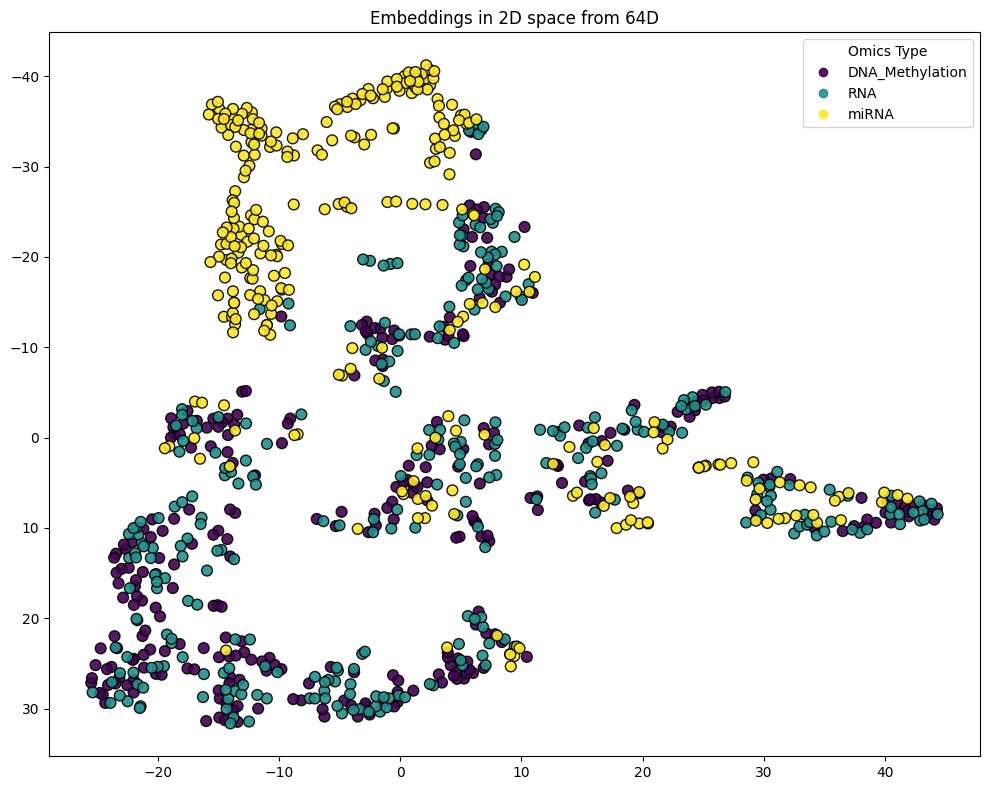

In [21]:
from bioneuralnet.metrics import plot_embeddings

# for a more interpretable embedding plot we will map the node labels to omics types
node_labels = []
GAT_embeddings_array = GAT_embeddings_df.values
feature_names = GAT_embeddings_df.index

# using the sets from the orginal to serve as a loopup table
dna_feats = set(dna_meth.columns)
rna_feats = set(rna.columns)
mirna_feats = set(mirna.columns)

for feat in feature_names:
    if feat in dna_feats:
        # 1 for DNA methylation
        node_labels.append(1)
    elif feat in rna_feats:
        # 2 for RNA 
        node_labels.append(2)
    elif feat in mirna_feats:
        # and 3 for miRNA 
        node_labels.append(3)
    else:
        node_labels.append(0)

# our plotting function needs an array to squeeze the embedings into 2Dspace
node_labels = np.array(node_labels)

# feature(omics) embeddings colored by omics type.
print(f"Plotting Feature Embeddings for graph: {res['graph']}")
plot_embeddings(GAT_embeddings_array, node_labels, legend_labels=["DNA_Methylation", "RNA", "miRNA"])

In [25]:
from bioneuralnet.clustering import HybridLouvain

labels = target["target"] 
unique_phenotypes = labels.unique()
multiclass_results = {}
summary = []
label_map = {0: "KIRC", 1: "KIRP", 2: "KICH"}

for phenotype in unique_phenotypes:
    y_binary = (labels == phenotype).astype(int)

    hl = HybridLouvain(
        G=similarity_10,
        B=omics_kipan,
        Y=y_binary,
        k3=0.2,
        k4=0.8,
        max_iter=3,
        seed=SEED,
    )

    subnetworks = hl.run(as_dfs=True)

    name = label_map.get(phenotype, str(phenotype))

    if subnetworks:
        df = subnetworks[0]
        multiclass_results[name] = df
        summary.append((name, df.shape[1]))
    else:
        summary.append((name, 0))

print("\nDriver modules (one-vs-rest):")
for name, n_feats in summary:
    print(f"  {name}: {n_feats} features")



2025-11-26 09:50:43,480 - bioneuralnet.utils.reproducibility - INFO - Setting global seed for reproducibility to: 8183
2025-11-26 09:50:43,481 - bioneuralnet.utils.reproducibility - INFO - CUDA available. Applying seed to all GPU operations
2025-11-26 09:50:43,481 - bioneuralnet.utils.reproducibility - INFO - Seed setting complete
2025-11-26 09:50:43,482 - bioneuralnet.clustering.hybrid_louvain - INFO - Initializing HybridLouvain...
2025-11-26 09:50:43,482 - bioneuralnet.clustering.hybrid_louvain - INFO - Input G is a DataFrame; converting adjacency matrix to NetworkX graph.
2025-11-26 09:50:43,494 - bioneuralnet.clustering.hybrid_louvain - INFO - Initialized HybridLouvain with 900 graph nodes, 900 omics columns, 658 phenotype rows; max_iter=3, k3=0.2, k4=0.8, tune=False
2025-11-26 09:50:43,495 - bioneuralnet.clustering.hybrid_louvain - INFO - 
Iteration 1/3: Running Correlated Louvain...
2025-11-26 09:50:43,504 - bioneuralnet.clustering.correlated_louvain - INFO - CorrelatedLouvain(k3


Driver modules (one-vs-rest):
  KIRP: 293 features
  KIRC: 159 features
  KICH: 69 features


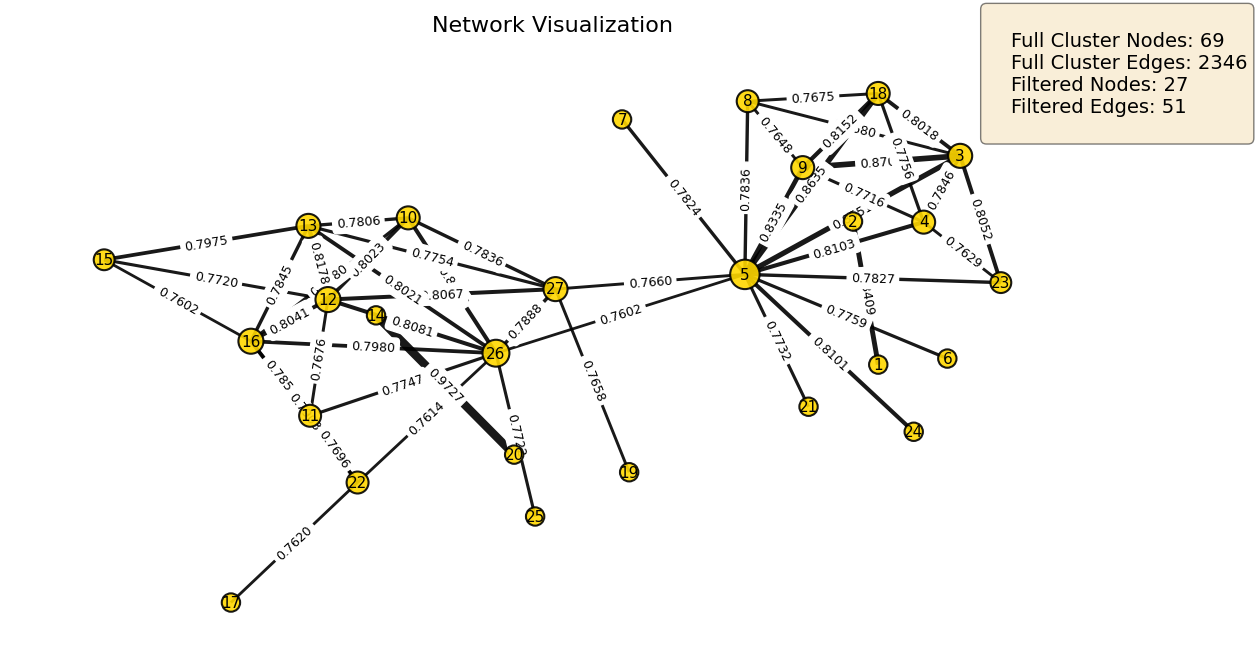

                   Omic  Degree
Index                          
5          INPP5J_27124      12
26       SLC26A7_115111       9
12      HEPACAM2_253012       7
16          CLNK_116449       7
27           RHCG_51458       6
3           CLCNKB_1188       6
13          DMRT2_10655       6
18     LOC643008_643008       5
10          SLC4A1_6521       5
9           CLCNKA_1187       5
4             FGF9_2254       5
11       C9orf84_158401       4
8          ATP6V1B1_525       4
22       KRTAP5_8_57830       4
15           FOXI1_2299       3
23       ATP6V0A4_50617       3
21      ATP6V0D2_245972       1
24         TMPRSS2_7113       1
25         GCOM1_145781       1
1         hsa_mir_129_1       1
20         hsa_mir_200c       1
19            KLK1_3816       1
17         hsa_mir_891a       1
2         hsa_mir_129_2       1
7        EPB41L4B_54566       1
6         TRIM50_135892       1
14          hsa_mir_141       1


In [50]:
from bioneuralnet.metrics import louvain_to_adjacency, plot_network

kirp_df = multiclass_results["KICH"]
kirp_adj = louvain_to_adjacency(kirp_df)
kirp_mapping = plot_network(kirp_adj, weight_threshold=0.76, show_labels=True, show_edge_weights=True)
print(kirp_mapping)

In [51]:
from bioneuralnet.metrics import find_omics_modality

# for those features in the KIRP module, we will identify their omics source
omics_df_list = [top_meth, top_rna, top_mirna]
source_names = ["DNA_Methylation", "RNA", "miRNA"]

kirp_mapping_with_source = find_omics_modality(kirp_mapping, omics_df_list, source_names)
display(kirp_mapping_with_source)

,Omic,Degree,Source
Index,,,
5,INPP5J_27124,12,RNA
26,SLC26A7_115111,9,RNA
12,HEPACAM2_253012,7,RNA
16,CLNK_116449,7,RNA
27,RHCG_51458,6,RNA
3,CLCNKB_1188,6,RNA
13,DMRT2_10655,6,RNA
18,LOC643008_643008,5,RNA
10,SLC4A1_6521,5,RNA


In [ ]:
dna_feats  = set(dna_meth.columns)
rna_feats  = set(rna.columns)
mirna_feats = set(mirna.columns)

def get_omics_type(feat):
    if feat in dna_feats:
        return "DNA_Methylation"
    elif feat in rna_feats:
        return "RNA"
    elif feat in mirna_feats:
        return "miRNA"
    else:
        return "Unknown"

# kirp_mapping is the DF returned by plot_network
kirp_mapping["OmicsType"] = kirp_mapping["Omic"].map(get_omics_type)

print(kirp_mapping)

In [10]:
output_dir_base = Path("/home/vicente/Github/BioNeuralNet/dpmon_results_SAGE_FINAL/kipan")
all_results_SAGE = []

for run_config in comparison_runs:
    graph_name = run_config["name"]
    A_full = run_config["graph"]
    
    current_output_dir = output_dir_base / graph_name
    current_output_dir.mkdir(parents=True, exist_ok=True)

    dpmon_params_base = {
        "adjacency_matrix": A_full,
        "omics_list": omics_kipan,
        "phenotype_data": target,
        "phenotype_col": "target",
        "clinical_data": clinical_for_model,
        "model": 'SAGE',
        "tune": True, 
        "cv": True,   
        "n_folds": 5,
        "repeat_num": 1,
        "gpu": True,
        "cuda": 0,
        "seed": SEED,
        "output_dir": current_output_dir
    }
    
    dpmon_tunned = DPMON(**dpmon_params_base)
    predictions_df, metrics, embeddings = dpmon_tunned.run()

    all_results_SAGE.append({
        "graph": graph_name,
        "predictions": predictions_df,
        "metrics": metrics,
        "embeddings": embeddings
    })

for res in all_results_SAGE:
    graph_name = res["graph"]
    graph_metrics = res["metrics"]
    
    acc_row = graph_metrics.loc[graph_metrics['Metric'] == 'Accuracy'].iloc[0]
    f1_macro_row = graph_metrics.loc[graph_metrics['Metric'] == 'F1 Macro'].iloc[0]
    f1_weighted_row = graph_metrics.loc[graph_metrics['Metric'] == 'F1 Weighted'].iloc[0]
    recall_row = graph_metrics.loc[graph_metrics['Metric'] == 'Recall'].iloc[0]
    auc_row = graph_metrics.loc[graph_metrics['Metric'] == 'AUC'].iloc[0]
    aupr_row = graph_metrics.loc[graph_metrics['Metric'] == 'AUPR'].iloc[0]
    
    acc_avg, acc_std = acc_row['Average'], acc_row['StdDev']
    f1_macro_avg, f1_macro_std = f1_macro_row['Average'], f1_macro_row['StdDev']
    f1_weighted_avg, f1_weighted_std = f1_weighted_row['Average'], f1_weighted_row['StdDev']
    recall_avg, recall_std = recall_row['Average'], recall_row['StdDev']
    auc_avg, auc_std = auc_row['Average'], auc_row['StdDev']
    aupr_avg, aupr_std = aupr_row['Average'], aupr_row['StdDev']

    print(f"\nResults for: {graph_name}")
    print(f"Accuracy (Avg +/- Std): {acc_avg:.4f} +/- {acc_std:.4f}")
    print(f"F1 Macro (Avg +/- Std): {f1_macro_avg:.4f}  +/- {f1_macro_std:.4f}")
    print(f"F1 Weighted (Avg +/- Std): {f1_weighted_avg:.4f} +/- {f1_weighted_std:.4f}")
    print(f"Recall: {recall_avg:.4f} +/- {recall_std:.4f}")
    print(f"AUC: {auc_avg:.4f} +/- {auc_std:.4f}")


2025-11-26 01:05:57,049 - bioneuralnet.downstream_task.dpmon - INFO - Output directory set to: /home/vicente/Github/BioNeuralNet/dpmon_results_SAGE_FINAL/kipan/threshold_10
2025-11-26 01:05:57,050 - bioneuralnet.downstream_task.dpmon - INFO - Initialized DPMON with model: SAGE
2025-11-26 01:05:57,051 - bioneuralnet.utils.reproducibility - INFO - Setting global seed for reproducibility to: 8183
2025-11-26 01:05:57,052 - bioneuralnet.utils.reproducibility - INFO - CUDA available. Applying seed to all GPU operations
2025-11-26 01:05:57,052 - bioneuralnet.utils.reproducibility - INFO - Seed setting complete
2025-11-26 01:05:57,052 - bioneuralnet.downstream_task.dpmon - INFO - Random seed set to: 8183
2025-11-26 01:05:57,063 - bioneuralnet.downstream_task.dpmon - INFO - Using GPU 0
2025-11-26 01:05:57,068 - bioneuralnet.downstream_task.dpmon - INFO - Running in Cross-Validation mode (cv=True) with 5 folds.
2025-11-26 01:05:57,071 - bioneuralnet.downstream_task.dpmon - INFO - CV Setup: Stand


Results for: threshold_10
Accuracy (Avg +/- Std): 0.9452 +/- 0.0303
F1 Macro (Avg +/- Std): 0.9345  +/- 0.0238
F1 Weighted (Avg +/- Std): 0.9452 +/- 0.0305
Recall: 0.9406 +/- 0.0141
AUC: 0.9949 +/- 0.0024

Results for: correlation_10
Accuracy (Avg +/- Std): 0.9467 +/- 0.0351
F1 Macro (Avg +/- Std): 0.9284  +/- 0.0495
F1 Weighted (Avg +/- Std): 0.9489 +/- 0.0306
Recall: 0.9487 +/- 0.0208
AUC: 0.9937 +/- 0.0050

Results for: similarity_10
Accuracy (Avg +/- Std): 0.9574 +/- 0.0149
F1 Macro (Avg +/- Std): 0.9515  +/- 0.0125
F1 Weighted (Avg +/- Std): 0.9576 +/- 0.0149
Recall: 0.9608 +/- 0.0135
AUC: 0.9944 +/- 0.0034

Results for: gaussian_15
Accuracy (Avg +/- Std): 0.9620 +/- 0.0153
F1 Macro (Avg +/- Std): 0.9585  +/- 0.0131
F1 Weighted (Avg +/- Std): 0.9621 +/- 0.0154
Recall: 0.9680 +/- 0.0126
AUC: 0.9943 +/- 0.0021


In [11]:
#This time we will select the gaussian_15 graph embeddings
res = all_results_SAGE[3] 
tensor_data = res["embeddings"]

# .detach().cpu().numpy() to get the raw numbers out of pytorch
SAGE_embeddings_df = pd.DataFrame(
    tensor_data.detach().cpu().numpy(),
    index=omics_kipan.columns
)

display(SAGE_embeddings_df.iloc[:5,:5])

,0,1,2,3,4
MGP,0.0,0.0,0.923418,0.000000,0.295637
ADH1C,0.0,0.0,0.521837,0.005931,0.421344
LOC440354,0.0,0.0,0.851917,0.000000,0.216582
C1orf110,0.0,0.0,0.625036,0.009498,0.256967
CLDN8,0.0,0.0,0.638092,0.000000,0.230229


Plotting Feature Embeddings for graph: correlation_10


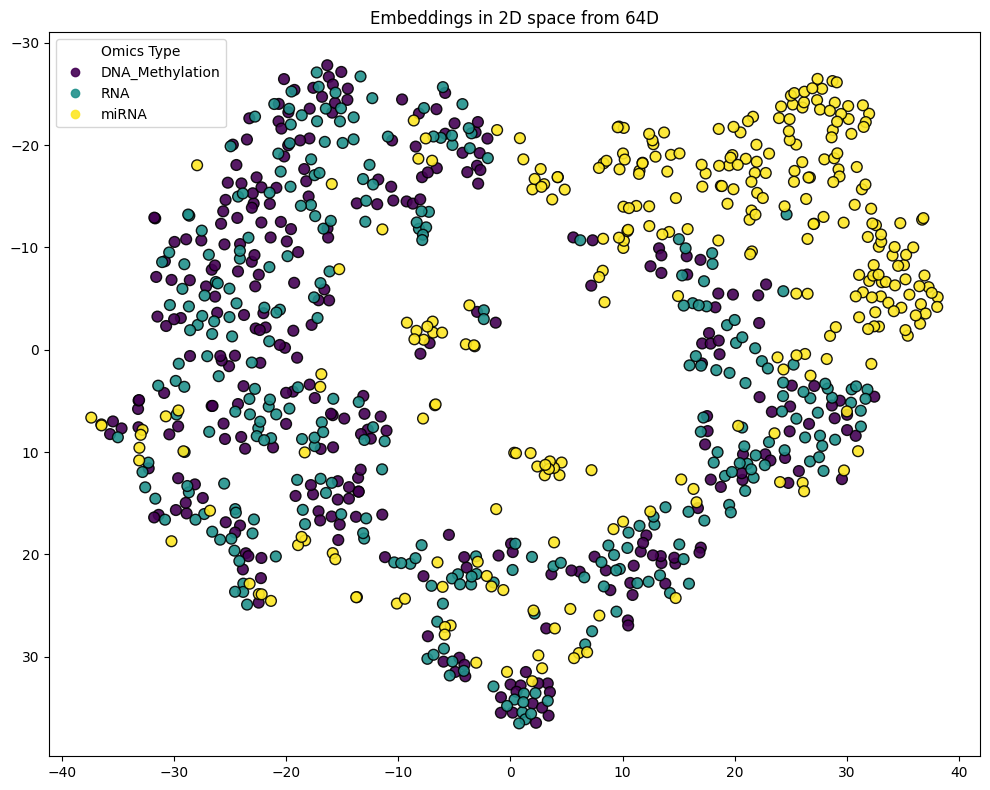

In [12]:
from bioneuralnet.metrics import plot_embeddings

# for a more interpretable embedding plot we will map the node labels to omics types
SAGE_node_labels = []
SAGE_embeddings_array = SAGE_embeddings_df.values
feature_names = SAGE_embeddings_df.index

# using the sets from the orginal to serve as a loopup table
dna_feats = set(dna_meth.columns)
rna_feats = set(rna.columns)
mirna_feats = set(mirna.columns)

for feat in feature_names:
    if feat in dna_feats:
        # 1 for DNA methylation
        SAGE_node_labels.append(1)
    elif feat in rna_feats:
        # 2 for RNA 
        SAGE_node_labels.append(2)
    elif feat in mirna_feats:
        # and 3 for miRNA 
        SAGE_node_labels.append(3)
    else:
        SAGE_node_labels.append(0)

# our plotting function needs an array to squeeze the embedings into 2Dspace
SAGE_node_labels = np.array(SAGE_node_labels)

# feature(omics) embeddings colored by omics type.
print(f"Plotting Feature Embeddings for graph: {res['graph']}")
plot_embeddings(SAGE_embeddings_array, SAGE_node_labels, legend_labels=["DNA_Methylation", "RNA", "miRNA"])

In [13]:
from bioneuralnet.clustering import HybridLouvain

labels = target["target"]
unique_phenotypes = labels.unique()

multiclass_results = {}
summary = []

for phenotype in unique_phenotypes:
    # one-vs-rest encoding
    y_binary = (labels == phenotype).astype(int)

    hl = HybridLouvain(
        G=correlation_10,
        B=omics_kipan,
        Y=y_binary,
        k3=0.2,
        k4=0.8,
        max_iter=3,
        seed=SEED,
    )

    subnetworks = hl.run(as_dfs=True)

    if subnetworks:
        df = subnetworks[0]
        multiclass_results[phenotype] = df
        summary.append((phenotype, df.shape[1]))
    else:
        summary.append((phenotype, 0))

print("\nDriver modules (one-vs-rest):")
for pheno, n_feats in summary:
    print(f"  {pheno}: {n_feats} features")

2025-11-26 01:12:46,329 - bioneuralnet.utils.reproducibility - INFO - Setting global seed for reproducibility to: 8183
2025-11-26 01:12:46,330 - bioneuralnet.utils.reproducibility - INFO - CUDA available. Applying seed to all GPU operations
2025-11-26 01:12:46,330 - bioneuralnet.utils.reproducibility - INFO - Seed setting complete
2025-11-26 01:12:46,330 - bioneuralnet.clustering.hybrid_louvain - INFO - Initializing HybridLouvain...
2025-11-26 01:12:46,331 - bioneuralnet.clustering.hybrid_louvain - INFO - Input G is a DataFrame; converting adjacency matrix to NetworkX graph.
2025-11-26 01:12:46,343 - bioneuralnet.clustering.hybrid_louvain - INFO - Initialized HybridLouvain with 900 graph nodes, 900 omics columns, 658 phenotype rows; max_iter=3, k3=0.2, k4=0.8, tune=False
2025-11-26 01:12:46,343 - bioneuralnet.clustering.hybrid_louvain - INFO - 
Iteration 1/3: Running Correlated Louvain...
2025-11-26 01:12:46,352 - bioneuralnet.clustering.correlated_louvain - INFO - CorrelatedLouvain(k3


Driver modules (one-vs-rest):
  1: 857 features
  0: 451 features
  2: 448 features


In [14]:
output_dir_base = Path("/home/vicente/Github/BioNeuralNet/dpmon_results_GCN_FINAL/kipan")

all_results_GCN = []

for run_config in comparison_runs:
    graph_name = run_config["name"]
    A_full = run_config["graph"]

    current_output_dir = output_dir_base / graph_name
    current_output_dir.mkdir(parents=True, exist_ok=True)

    dpmon_params_base = {
        "adjacency_matrix": A_full,
        "omics_list": omics_kipan,
        "phenotype_data": target,
        "phenotype_col": "target",
        "clinical_data": clinical_for_model,
        "model": 'GCN',
        "tune": True, 
        "cv": True,   
        "n_folds": 5,
        "repeat_num": 1,
        "gpu": True,
        "cuda": 0,
        "seed": SEED,
        "output_dir": current_output_dir
    }
    
    dpmon_tunned = DPMON(**dpmon_params_base)
    predictions_df, metrics, embeddings = dpmon_tunned.run()

    all_results_GCN.append({
        "graph": graph_name,
        "predictions": predictions_df,
        "metrics": metrics,
        "embeddings": embeddings
    })

for res in all_results_GCN:
    graph_name = res["graph"]
    graph_metrics = res["metrics"]
    
    acc_row = graph_metrics.loc[graph_metrics['Metric'] == 'Accuracy'].iloc[0]
    f1_macro_row = graph_metrics.loc[graph_metrics['Metric'] == 'F1 Macro'].iloc[0]
    f1_weighted_row = graph_metrics.loc[graph_metrics['Metric'] == 'F1 Weighted'].iloc[0]
    recall_row = graph_metrics.loc[graph_metrics['Metric'] == 'Recall'].iloc[0]
    auc_row = graph_metrics.loc[graph_metrics['Metric'] == 'AUC'].iloc[0]
    aupr_row = graph_metrics.loc[graph_metrics['Metric'] == 'AUPR'].iloc[0]
    
    acc_avg, acc_std = acc_row['Average'], acc_row['StdDev']
    f1_macro_avg, f1_macro_std = f1_macro_row['Average'], f1_macro_row['StdDev']
    f1_weighted_avg, f1_weighted_std = f1_weighted_row['Average'], f1_weighted_row['StdDev']
    recall_avg, recall_std = recall_row['Average'], recall_row['StdDev']
    auc_avg, auc_std = auc_row['Average'], auc_row['StdDev']
    aupr_avg, aupr_std = aupr_row['Average'], aupr_row['StdDev']

    print(f"\nResults for: {graph_name}")
    print(f"Accuracy (Avg +/- Std): {acc_avg:.4f} +/- {acc_std:.4f}")
    print(f"F1 Macro (Avg +/- Std): {f1_macro_avg:.4f}  +/- {f1_macro_std:.4f}")
    print(f"F1 Weighted (Avg +/- Std): {f1_weighted_avg:.4f} +/- {f1_weighted_std:.4f}")
    print(f"Recall: {recall_avg:.4f} +/- {recall_std:.4f}")
    print(f"AUC: {auc_avg:.4f} +/- {auc_std:.4f}")

2025-11-26 01:14:04,056 - bioneuralnet.downstream_task.dpmon - INFO - Output directory set to: /home/vicente/Github/BioNeuralNet/dpmon_results_GCN_FINAL/kipan/threshold_10
2025-11-26 01:14:04,057 - bioneuralnet.downstream_task.dpmon - INFO - Initialized DPMON with model: GCN
2025-11-26 01:14:04,057 - bioneuralnet.utils.reproducibility - INFO - Setting global seed for reproducibility to: 8183
2025-11-26 01:14:04,058 - bioneuralnet.utils.reproducibility - INFO - CUDA available. Applying seed to all GPU operations
2025-11-26 01:14:04,058 - bioneuralnet.utils.reproducibility - INFO - Seed setting complete
2025-11-26 01:14:04,059 - bioneuralnet.downstream_task.dpmon - INFO - Random seed set to: 8183
2025-11-26 01:14:04,064 - bioneuralnet.downstream_task.dpmon - INFO - Using GPU 0
2025-11-26 01:14:04,067 - bioneuralnet.downstream_task.dpmon - INFO - Running in Cross-Validation mode (cv=True) with 5 folds.
2025-11-26 01:14:04,068 - bioneuralnet.downstream_task.dpmon - INFO - CV Setup: Standar


Results for: threshold_10
Accuracy (Avg +/- Std): 0.9574 +/- 0.0175
F1 Macro (Avg +/- Std): 0.9536  +/- 0.0165
F1 Weighted (Avg +/- Std): 0.9576 +/- 0.0175
Recall: 0.9651 +/- 0.0138
AUC: 0.9943 +/- 0.0029

Results for: correlation_10
Accuracy (Avg +/- Std): 0.9574 +/- 0.0139
F1 Macro (Avg +/- Std): 0.9480  +/- 0.0134
F1 Weighted (Avg +/- Std): 0.9578 +/- 0.0137
Recall: 0.9571 +/- 0.0035
AUC: 0.9965 +/- 0.0028

Results for: similarity_10
Accuracy (Avg +/- Std): 0.9513 +/- 0.0185
F1 Macro (Avg +/- Std): 0.9390  +/- 0.0210
F1 Weighted (Avg +/- Std): 0.9519 +/- 0.0183
Recall: 0.9567 +/- 0.0230
AUC: 0.9925 +/- 0.0055

Results for: gaussian_15
Accuracy (Avg +/- Std): 0.9590 +/- 0.0087
F1 Macro (Avg +/- Std): 0.9434  +/- 0.0084
F1 Weighted (Avg +/- Std): 0.9592 +/- 0.0088
Recall: 0.9546 +/- 0.0190
AUC: 0.9949 +/- 0.0030


In [15]:
#This time we will select the gaussian_15 graph embeddings
res = all_results_GCN[3] 
tensor_data = res["embeddings"]

# .detach().cpu().numpy() to get the raw numbers out of pytorch
GCN_embeddings_df = pd.DataFrame(
    tensor_data.detach().cpu().numpy(),
    index=omics_kipan.columns
)

display(GCN_embeddings_df.iloc[:5,:5])

,0,1,2,3,4
MGP,0.035549,0.001088,0.0,0.0,0.003548
ADH1C,0.000000,0.000253,0.0,0.0,0.026202
LOC440354,0.000000,0.002382,0.0,0.0,0.000000
C1orf110,0.000000,0.000261,0.0,0.0,0.060484
CLDN8,0.000000,0.001527,0.0,0.0,0.004444


Plotting Feature Embeddings for graph: similarity_10


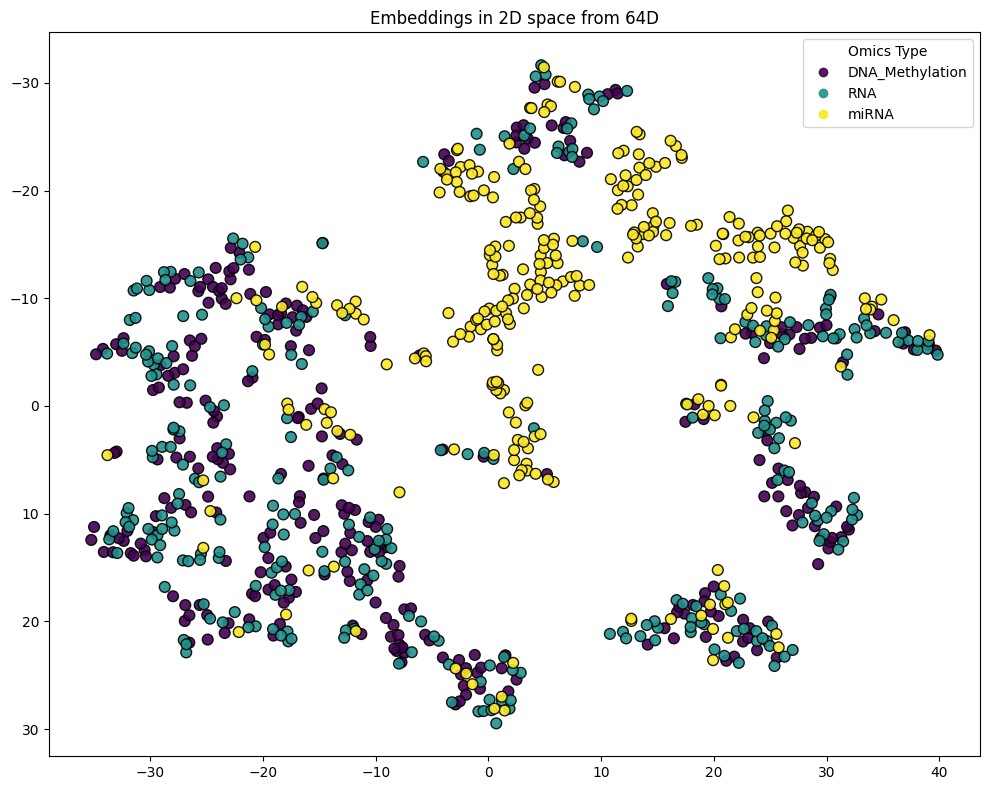

In [16]:
from bioneuralnet.metrics import plot_embeddings

# for a more interpretable embedding plot we will map the node labels to omics types
GCN_node_labels = []
GCN_embeddings_array = GCN_embeddings_df.values
feature_names = GCN_embeddings_df.index

# using the sets from the orginal to serve as a loopup table
dna_feats = set(dna_meth.columns)
rna_feats = set(rna.columns)
mirna_feats = set(mirna.columns)

for feat in feature_names:
    if feat in dna_feats:
        # 1 for DNA methylation
        GCN_node_labels.append(1)
    elif feat in rna_feats:
        # 2 for RNA 
        GCN_node_labels.append(2)
    elif feat in mirna_feats:
        # and 3 for miRNA 
        GCN_node_labels.append(3)
    else:
        GCN_node_labels.append(0)

# our plotting function needs an array to squeeze the embedings into 2Dspace
GCN_node_labels = np.array(GCN_node_labels)

# feature(omics) embeddings colored by omics type.
print(f"Plotting Feature Embeddings for graph: {res['graph']}")
plot_embeddings(GCN_embeddings_array, GCN_node_labels, legend_labels=["DNA_Methylation", "RNA", "miRNA"])